In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import os, datetime

Populating the interactive namespace from numpy and matplotlib


In [2]:
LonFrom = -74.25559
LonTo = -73.70001
LatFrom = 40.49612
LatTo = 40.91553
regions = pd.read_csv("regions.csv",";")

In [3]:
def getRegion (longitude, latitude):
    binsX = np.linspace(LonFrom, LonTo, 51)
    binsY = np.linspace(LatFrom, LatTo, 51)
    reg = stats.binned_statistic_2d(longitude, latitude, None, 
                                              statistic = "count", bins = [binsX, binsY], expand_binnumbers=True)
    return (reg.binnumber[0] - 1) * 50 + reg.binnumber[1]


def grouped_data(tripdata):
    tripdata = tripdata[(tripdata['trip_distance'] != 0) & 
          (tripdata['passenger_count'] != 0) &
          (tripdata['tpep_pickup_datetime'] != tripdata['tpep_dropoff_datetime']) &
          (tripdata['pickup_longitude'] > LonFrom) &
          (tripdata['pickup_longitude'] < LonTo) &
          (tripdata['pickup_latitude'] > LatFrom) &
          (tripdata['pickup_latitude'] < LatTo)]

    tripdata['region'] = getRegion(tripdata.pickup_longitude, tripdata.pickup_latitude)

    tripdata.loc[:,'tpep_pickup_datetime'] = tripdata.tpep_pickup_datetime.dt.floor('h')

    tripdata_grouped = tripdata.groupby(['tpep_pickup_datetime', 'region']).size().reset_index(name='counts')
    tripdata_grouped = tripdata_grouped.set_index('tpep_pickup_datetime')
    return tripdata_grouped


In [4]:
esb_hourly = pd.DataFrame()
group_tripdata = pd.DataFrame()
for filename in os.listdir("rawdata"):
    print("started processing " + filename)
    if filename.endswith("csv"): 
        tripdata = pd.read_csv("rawdata/" + filename,",", 
                           parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
        group_tripdata = grouped_data(tripdata)
        esb_hourly = esb_hourly.append(group_tripdata[group_tripdata["region"] == 1231])
    
esb_hourly = esb_hourly.sort_values(by = "tpep_pickup_datetime")
esb_hourly.to_csv("esb_hourly.csv", sep=',')

started processing yellow_tripdata_2015-05.csv


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


started processing yellow_tripdata_2015-11.csv
started processing yellow_tripdata_2015-10.csv
started processing yellow_tripdata_2015-04.csv
started processing yellow_tripdata_2015-12.csv
started processing yellow_tripdata_2015-06.csv
started processing yellow_tripdata_2015-07.csv
started processing yellow_tripdata_2015-03.csv
started processing .DS_Store
started processing yellow_tripdata_2015-02.csv
started processing yellow_tripdata_2015-01.csv
started processing yellow_tripdata_2013-07.csv


/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


started processing yellow_tripdata_2013-12.csv
started processing yellow_tripdata_2013-06.csv
started processing yellow_tripdata_2013-10.csv
started processing yellow_tripdata_2013-04.csv
started processing yellow_tripdata_2013-05.csv
started processing yellow_tripdata_2013-11.csv
started processing yellow_tripdata_2014-08.csv
started processing yellow_tripdata_2013-01.csv
started processing yellow_tripdata_2014-09.csv
started processing yellow_tripdata_2013-02.csv
started processing yellow_tripdata_2013-03.csv
started processing yellow_tripdata_2016-02.csv
started processing yellow_tripdata_2014-07.csv
started processing yellow_tripdata_2014-06.csv
started processing yellow_tripdata_2014-12.csv
started processing yellow_tripdata_2016-03.csv
started processing yellow_tripdata_2016-01.csv
started processing yellow_tripdata_2014-04.csv
started processing yellow_tripdata_2014-10.csv
started processing yellow_tripdata_2014-11.csv
started processing yellow_tripdata_2014-05.csv
started proce

In [5]:
esb_hourly = pd.read_csv("esb_hourly.csv", sep = ",", parse_dates=['tpep_pickup_datetime'],
                   index_col = "tpep_pickup_datetime")

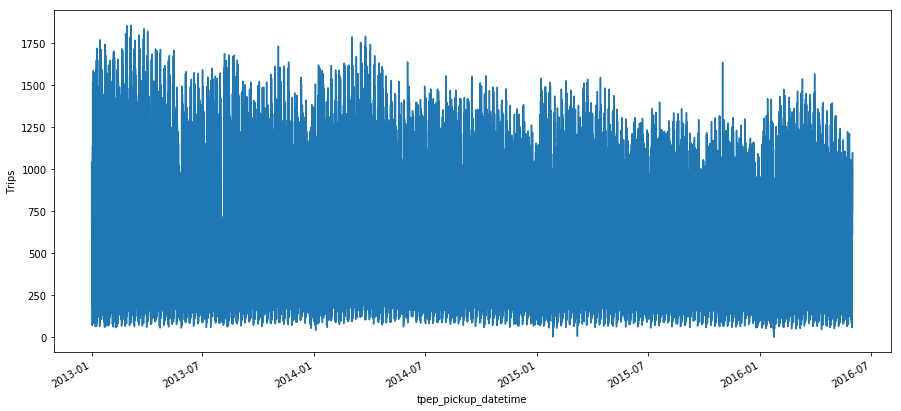

In [6]:
plt.figure(figsize(15,7))
esb_hourly.counts.plot()
plt.ylabel('Trips')
pylab.show()

In [32]:
dt_from = datetime.datetime.strptime("2016-05-01 00:00:00", "%Y-%m-%d %H:%M:%S")
dt_to = datetime.datetime.strptime("2016-05-31 23:00:00", "%Y-%m-%d %H:%M:%S")
esb_hourly_may = data[(data.index <= dt_to) & 
          (data.index >= dt_from)]

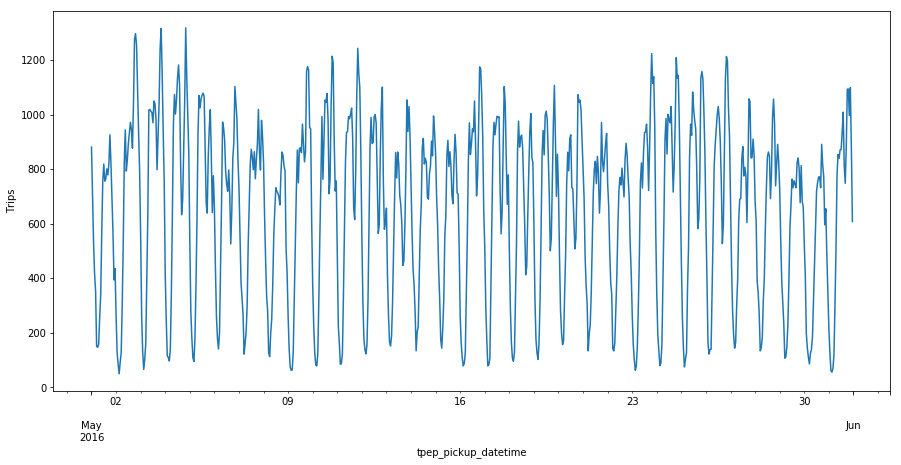

In [34]:
plt.figure(figsize(15,7))
esb_hourly.counts.plot()
plt.ylabel('Trips')
pylab.show()

In [50]:
data = pd.read_csv("esb_hourly1.csv", sep = ",", parse_dates=['tpep_pickup_datetime'],
                   index_col = "tpep_pickup_datetime")

dt_from = datetime.datetime.strptime("2016-05-01 00:00:00", "%Y-%m-%d %H:%M:%S")
dt_to = datetime.datetime.strptime("2016-05-31 23:00:00", "%Y-%m-%d %H:%M:%S")
esb_hourly_may = data[(data.index <= dt_to) & 
          (data.index >= dt_from)]

,region,counts
tpep_pickup_datetime,,
2015-01-01 00:00:00,1231,1125
2015-01-01 01:00:00,1231,922
2015-01-01 02:00:00,1231,767
2015-01-01 03:00:00,1231,774
2015-01-01 04:00:00,1231,548


In [ ]:
plt.figure(figsize(15,7))
esb_hourly.counts.plot()
plt.ylabel('Trips')
pylab.show()